In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from numpy import linalg as LA
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.python.framework import ops
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)
x_train = np.reshape(x_train, (x_train.shape[0], 32*32*3))
x_test = np.reshape(x_test, (x_test.shape[0], 32*32*3))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)



x_train shape: (50000, 3072)
50000 train samples
10000 test samples


In [7]:
class SNVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, K, learning_rate=1e-3):
        self.K = K
        self._learning_rate = learning_rate
        
        self._grads_and_vars = self._compute_gradients(loss)
        
        self._reference_gradient_ph = [[tf.placeholder(tf.float32, shape=v.get_shape()) for _, v in self._grads_and_vars]
                                       for _ in range(self.K+1)]
        
        self._update = self._compute_single_update
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
            
    def _compute_single_update(self, l):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (_, v) in enumerate(grads_and_vars):
            g = self._reference_gradient_ph[l][i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, feed_dict_total, n, batch_size, loop_params, mini_batch_params, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        input_total_ph = list(feed_dict_total.keys())
        input_total_data = list(feed_dict_total.values())
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        gs, vs = zip(*self._grads_and_vars)
        shift_gradients = []
        for l in range(K+1):
            gss = []
            for g in gs:
                gss.append(tf.identity(g))
                
            shift_gradients.append(gss)
        
        reference_gradients = [[np.zeros(v.get_shape().as_list()) for v in vs] for _ in range(self.K+1)]
        reference_gradients[0] = sess.run(gs, feed_dict=feed_dict)
        
        feed_dict.update(dict(zip(self._reference_gradient_ph[0], reference_gradients[0])))
        _ = sess.run(self._update(0), feed_dict=feed_dict)

        for t in range(1, np.prod(loop_params)):      
            gs, vs = zip(*self._grads_and_vars)
            
            r = find_index(t, loop_params)
            
            for l in range(r, K+1):
                samples = np.random.choice(n, size = mini_batch_params[l-1], replace=False)
                feed_dict_single = {input_total_ph[j]: input_total_data[j][samples] for j in range(len(input_total_data))}
                
                gss = []
                for g in gs:
                    gss.append(tf.identity(g))
                shift_gradients[l] = gss
                
                for i, g in enumerate(shift_gradients[l]):
                    reference_gradients[l][i] = sess.run(g - shift_gradients[l-1][i], feed_dict=feed_dict_single)
                
            for l in range(K+1):
                feed_dict_single.update(dict(zip(self._reference_gradient_ph[l], reference_gradients[l])))
                _ = sess.run(self._update(l), feed_dict=feed_dict_single)

class SVRGOptimizer(tf.train.Optimizer):
    def __init__(self, loss, learning_rate=1e-3):
        self._learning_rate = learning_rate

        self._grads_and_vars = self._compute_gradients(loss)
        
        self._variance_reduction_ph = [tf.placeholder(tf.float32, shape=v.get_shape()) 
                                           for _, v in self._grads_and_vars]
        self._bias_correction_ph = [tf.placeholder(tf.float32, shape=v.get_shape())
                                           for _, v in self._grads_and_vars]
    
        self._update = self._compute_single_update()
        
    def _compute_gradients(self, loss):
        opt = tf.train.GradientDescentOptimizer(learning_rate=1)
        grads_and_vars = opt.compute_gradients(loss)
        grads_and_vars = [(g, v) for g, v in grads_and_vars if not isinstance(g, ops.IndexedSlices)]
        
        return grads_and_vars
    
    def _compute_single_update(self):
        grads_and_vars = self._grads_and_vars
        
        update_ops = []
        for i, (g, v) in enumerate(grads_and_vars):
            g += self._bias_correction_ph[i] - self._variance_reduction_ph[i]
            
            update = - self._learning_rate * g
            update_ops.append(v.assign_add(update))
            
        return tf.group(*update_ops)
    
    def batch_update(self, sess, feed_dict, batch_size, inner_iter, lr=None):
        if lr is not None:
            self._learning_rate = lr
        
        feed_dict_single = []
        gs, _ = zip(*self._grads_and_vars)
        bias_correction = sess.run(gs, feed_dict=feed_dict)
        
        input_ph = list(feed_dict.keys())
        input_data = list(feed_dict.values())
        
        for i in range(inner_iter):
            sample = np.random.randint(batch_size)
            feed_dict_single.append({input_ph[j]: input_data[j][sample:sample+1] for j in range(len(input_data))})
            
        for i in range(inner_iter):
            single_grads_and_vars = sess.run(gs, feed_dict=feed_dict_single[i])
            
            _feed_dict = feed_dict_single[i]
            _feed_dict.update(dict(zip(self._bias_correction_ph, bias_correction)))
            _feed_dict.update(dict(zip(self._variance_reduction_ph, single_grads_and_vars)))
            
            _ = sess.run(self._update, feed_dict=_feed_dict)

In [8]:
def loss(y, pred):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=pred))
    return cross_entropy

def CNN_LeNet(images):
    net = tf.reshape(images, shape=[-1, 32, 32, 3])
    net = Conv2D(filters=6, kernel_size=5, strides=(1, 1), activation='relu', padding='SAME')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Conv2D(filters=16, kernel_size=5, strides=(1, 1), activation='relu', padding='VALID')(net)
    net = MaxPool2D(strides=(2, 2))(net)
    net = Flatten()(net)
    net = Dense(120, activation='relu')(net)
    net = Dense(84, activation='relu')(net)
    net = Dense(10, activation=None)(net)
    
    return net

import random
def pack_batch(features, targets, dataset_size, batch_size):
    x_batch = []
    y_batch = []
    for i in range(batch_size):
        index = random.randint(0, dataset_size-1)
        x_batch.append(features[index])
        y_batch.append(targets[index])
    return np.array(x_batch), np.array(y_batch)

def evaluate(y, y_pred):
    preds = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y, axis=1)
    err = 1. - tf.reduce_mean(tf.cast(tf.equal(y_true, preds), tf.float32))
    return err
# Define the function to find the mod index
def find_index(t, loop_params):
    """ finds r = min{j: 0=(m mod Prod(T_l)), 0<=j<=K}
    """
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0


In [12]:
tf.reset_default_graph()

lr = 0.005
epochs = 100
BATCH_SIZE = 512

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    sgd_loss_history = []
    sgd_test_error_history = []
    sgd_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
#         batch = mnist.train.next_batch(batch_size)

        nBatches = int(x_train.shape[0]/BATCH_SIZE)
        for i in range(nBatches):
            
            x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], BATCH_SIZE)
            feed_dict = {X: x_batch, y: y_batch}
            _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
            nb_grads += BATCH_SIZE

        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        sgd_loss_history.append(c)
        sgd_test_error_history.append(err)
        sgd_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))


Epoch 1/100
	Loss: 2.290587902069092 	Test Error: 0.8658000230789185
Epoch 2/100
	Loss: 2.2666118144989014 	Test Error: 0.8521000146865845
Epoch 3/100
	Loss: 2.2214221954345703 	Test Error: 0.8097000122070312
Epoch 4/100
	Loss: 2.165189504623413 	Test Error: 0.7741000056266785
Epoch 5/100
	Loss: 2.0732436180114746 	Test Error: 0.7563999891281128
Epoch 6/100
	Loss: 2.037607431411743 	Test Error: 0.7396999597549438
Epoch 7/100
	Loss: 1.993410348892212 	Test Error: 0.7179999947547913
Epoch 8/100
	Loss: 1.992366075515747 	Test Error: 0.7142000198364258
Epoch 9/100
	Loss: 1.9018216133117676 	Test Error: 0.6951000094413757
Epoch 10/100
	Loss: 1.9182207584381104 	Test Error: 0.6863000392913818
Epoch 11/100
	Loss: 1.9420721530914307 	Test Error: 0.6836999654769897
Epoch 12/100
	Loss: 1.89610755443573 	Test Error: 0.6696000099182129
Epoch 13/100
	Loss: 1.8918862342834473 	Test Error: 0.6640999913215637
Epoch 14/100
	Loss: 1.8997654914855957 	Test Error: 0.6606000065803528
Epoch 15/100
	Loss: 1.

In [13]:
tf.reset_default_graph()

lr = 0.005
momentum=0.9
epochs = 100
BATCH_SIZE = 512

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

opt = tf.train.MomentumOptimizer(learning_rate=lr, momentum= momentum)
optimizer = opt.minimize(cost)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    sgdM_loss_history = []
    sgdM_test_error_history = []
    sgdM_nb_grads = []
    sgdM_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
    
        nBatches = int(x_train.shape[0]/BATCH_SIZE)

        for i in range(nBatches):
            x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], BATCH_SIZE)
            feed_dict = {X: x_batch, y: y_batch}
            _, c = sess.run([optimizer, cost], feed_dict=feed_dict)
            nb_grads += BATCH_SIZE

        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        sgdM_loss_history.append(c)
        sgdM_test_error_history.append(err)
        sgdM_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))


Epoch 1/100
	Loss: 2.0787148475646973 	Test Error: 0.7430999875068665
Epoch 2/100
	Loss: 1.881821632385254 	Test Error: 0.6640000343322754
Epoch 3/100
	Loss: 1.7231953144073486 	Test Error: 0.6110999584197998
Epoch 4/100
	Loss: 1.6232514381408691 	Test Error: 0.5737999677658081
Epoch 5/100
	Loss: 1.4897170066833496 	Test Error: 0.5536999702453613
Epoch 6/100
	Loss: 1.4953181743621826 	Test Error: 0.5235999822616577
Epoch 7/100
	Loss: 1.2950800657272339 	Test Error: 0.5175999999046326
Epoch 8/100
	Loss: 1.474999189376831 	Test Error: 0.5188000202178955
Epoch 9/100
	Loss: 1.40384840965271 	Test Error: 0.4916999936103821
Epoch 10/100
	Loss: 1.3233330249786377 	Test Error: 0.48559999465942383
Epoch 11/100
	Loss: 1.3402276039123535 	Test Error: 0.4628000259399414
Epoch 12/100
	Loss: 1.2479162216186523 	Test Error: 0.4659000039100647
Epoch 13/100
	Loss: 1.259468913078308 	Test Error: 0.44859999418258667
Epoch 14/100
	Loss: 1.2338570356369019 	Test Error: 0.44690001010894775
Epoch 15/100
	Los

In [14]:
tf.reset_default_graph()

max_iter_inner = 64
lr = 0.005
epochs = 100
batch_size = 512

X = tf.placeholder(dtype='float32', shape=(None, x_train.shape[1]))
y = tf.placeholder(dtype='float32', shape=(None, y_train.shape[1]))

y_pred = CNN_LeNet(X)
cost = loss(y, y_pred)

optimizer = SVRGOptimizer(cost, lr)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    svrg_loss_history = []
    svrg_test_error_history = []
    svrg_nb_grads = []
    nb_grads = 0
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        # learning rate decay every 50 epochs
#         if epoch % 20 == 0 and epoch != 0:
#             lr *= 0.9
        nBatches = int(x_train.shape[0]/BATCH_SIZE)
        for i in range(nBatches):
            x_batch,y_batch = pack_batch(x_train, y_train, x_train.shape[0], BATCH_SIZE)
            feed_dict = {X: x_batch, y: y_batch}
            optimizer.batch_update(sess, feed_dict, batch_size, max_iter_inner, lr)
            nb_grads += batch_size + max_iter_inner
        
        c = sess.run(cost, feed_dict=feed_dict)
        
        test_error = evaluate(y, y_pred)
        err = sess.run(test_error, feed_dict={X: x_test, y: y_test})
        
        
        svrg_loss_history.append(c)
        svrg_test_error_history.append(err)
        svrg_nb_grads.append(nb_grads)
        print("\tLoss: {} \tTest Error: {}".format(c, err))

Epoch 1/100
	Loss: 2.287342071533203 	Test Error: 0.839900016784668
Epoch 2/100
	Loss: 2.2891016006469727 	Test Error: 0.8826000094413757
Epoch 3/100
	Loss: 2.2988600730895996 	Test Error: 0.899399995803833
Epoch 4/100
	Loss: 2.3009612560272217 	Test Error: 0.8827000260353088
Epoch 5/100
	Loss: 2.2264442443847656 	Test Error: 0.8104000091552734
Epoch 6/100
	Loss: 2.2169148921966553 	Test Error: 0.8393999934196472
Epoch 7/100
	Loss: 1.7245497703552246 	Test Error: 0.6398000121116638
Epoch 8/100
	Loss: 1.9591888189315796 	Test Error: 0.7074999809265137
Epoch 9/100
	Loss: 1.6557950973510742 	Test Error: 0.6341999769210815
Epoch 10/100
	Loss: 1.7939972877502441 	Test Error: 0.6572999954223633
Epoch 11/100
	Loss: 1.42598557472229 	Test Error: 0.5701000094413757
Epoch 12/100
	Loss: 1.3250681161880493 	Test Error: 0.5363999605178833
Epoch 13/100
	Loss: 1.5760908126831055 	Test Error: 0.6062999963760376
Epoch 14/100
	Loss: 1.4314302206039429 	Test Error: 0.546999990940094
Epoch 15/100
	Loss: 1

No handles with labels found to put in legend.


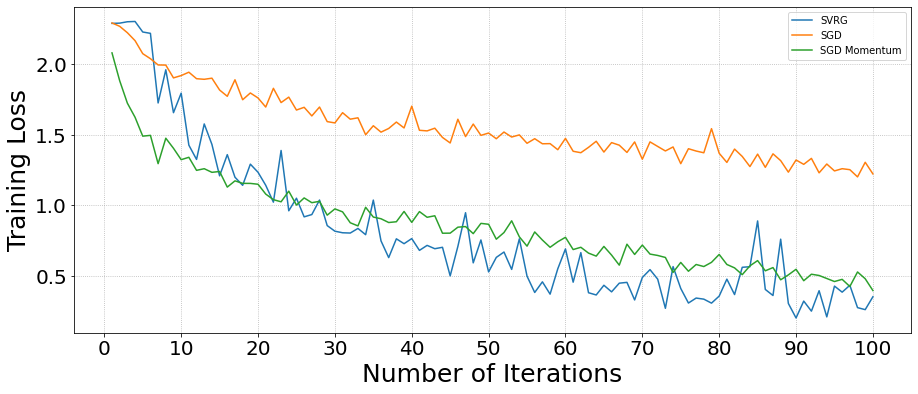

No handles with labels found to put in legend.


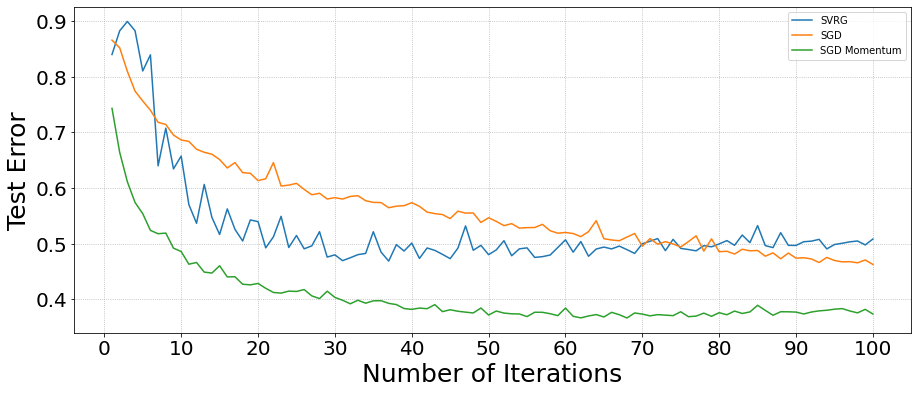

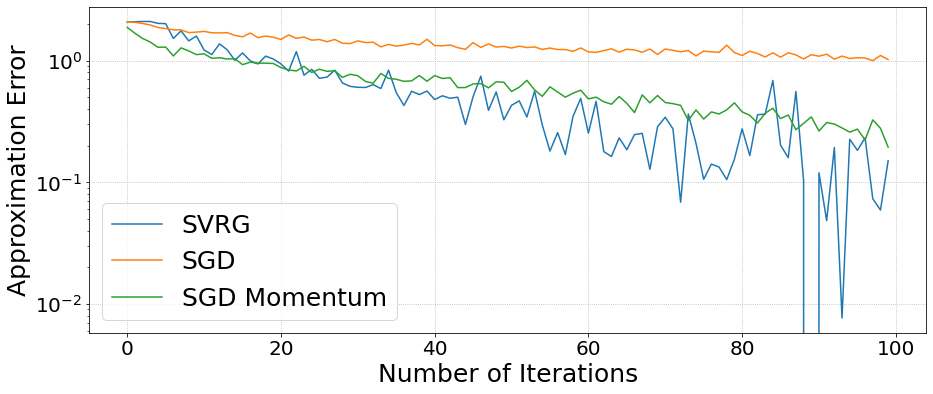

In [15]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
# plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_loss_history,  label ="SGD")
plt.plot(np.arange(1,epochs+1,1), sgdM_loss_history,  label ="SGD Momentum")

plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
# plt.plot(np.arange(1,epochs+1,1), snvrg_test_error_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), svrg_test_error_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_test_error_history, label = "SGD")
plt.plot(np.arange(1,epochs+1,1), sgdM_test_error_history, label = "SGD Momentum")
plt.legend()
plt.show()

min_loss= np.min([np.min(svrg_loss_history),np.min(sgd_loss_history),np.min(sgdM_loss_history)])
plt.figure(figsize=(15, 6))
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', )
plt.semilogy(sgd_loss_history - min_loss, label='SGD', )
plt.semilogy(sgdM_loss_history -  min_loss, label='SGD Momentum', )
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

In [16]:
# import numpy

# np.savetxt("SGD_loss_cifar_lenet_b512_005.csv", sgd_loss_history, delimiter=",")
# np.savetxt("SGD_err_cifar_lenet_b512_005.csv", sgd_test_error_history, delimiter=",")


# np.savetxt("SGDM_loss_cifar_lenet_b512_005.csv", sgdM_loss_history, delimiter=",")
# np.savetxt("SGDM_err_cifar_lenet_b512_005.csv", sgdM_test_error_history, delimiter=",")


No handles with labels found to put in legend.


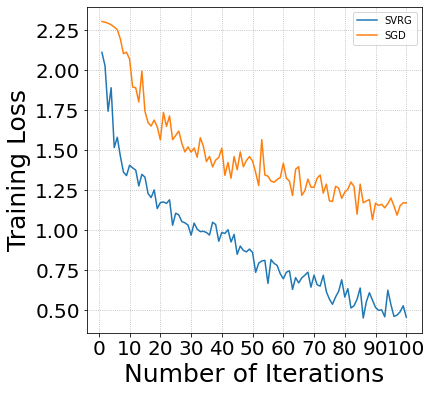

In [35]:
plt.figure(figsize=(6, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
# plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_loss_history,  label ="SGD")
# plt.plot(np.arange(1,epochs+1,1), sgdM_loss_history,  label ="SGD Momentum")

plt.legend()
plt.show()

In [1]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
# plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_loss_history,  label ="SGD")
plt.plot(np.arange(1,epochs+1,1), sgdM_loss_history,  label ="SGD Momentum")

plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
# plt.plot(np.arange(1,epochs+1,1), snvrg_test_error_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), svrg_test_error_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), sgd_test_error_history, label = "SGD")
plt.plot(np.arange(1,epochs+1,1), sgdM_test_error_history, label = "SGD Momentum")
plt.legend()
plt.show()

min_loss= np.min([np.min(svrg_loss_history),np.min(sgd_loss_history),np.min(sgdM_loss_history)])
plt.figure(figsize=(15, 6))
plt.semilogy(svrg_loss_history - min_loss, label='SVRG', )
plt.semilogy(sgd_loss_history - min_loss, label='SGD', )
plt.semilogy(sgdM_loss_history -  min_loss, label='SGD Momentum', )
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Approximation Error', fontsize=25)
plt.show()

NameError: name 'plt' is not defined